#Import Important Libraries 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, AveragePooling2D, Conv2D, Flatten, BatchNormalization, Add, MaxPool2D, ZeroPadding2D, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as k
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go

from google.colab import files
%matplotlib inline

In [2]:
sales_df = pd.read_csv('/content/drive/MyDrive/AI+in+Marketing+Dataset/AI in Marketing Dataset/sales_data_sample.csv', encoding = 'unicode_escape')

In [3]:
sales_df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [4]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [5]:
#NOTE: MSRP is the manufacturer's suggested retail price (MSRP) or sticker price represents the suggested retail price of products. 
# MSRP is used to standardize the price of products over multiple company store locations.

In [6]:
sales_df['ORDERDATE'].dtypes

dtype('O')

In [7]:
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])

In [8]:
sales_df['ORDERDATE'].dtypes

dtype('<M8[ns]')

In [9]:
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [10]:
sales_df['ADDRESSLINE2'].isnull().sum().sum()

2521

In [11]:
sales_df['ADDRESSLINE2'].isnull().sum()

2521

In [12]:
sales_df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [13]:
# since there are lot of Null values in 'addressline2', 'state', 'postal code' and 'territory' we can drop them. 
# Country would represent the order grographical information.
# Also we can drop city, address1, phone number, contact_name, contact last_name and contact first_name since they are not required for the analysis

drop_df = ['ADDRESSLINE2', 'ADDRESSLINE1', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop( drop_df, axis = 1)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,STATE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,NY,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,NaN,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,NaN,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,CA,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,CA,USA,Medium


In [14]:
sales_df.shape

(2823, 15)

In [15]:
sales_df.dtypes

QUANTITYORDERED             int64
PRICEEACH                 float64
ORDERLINENUMBER             int64
SALES                     float64
ORDERDATE          datetime64[ns]
STATUS                     object
QTR_ID                      int64
MONTH_ID                    int64
YEAR_ID                     int64
PRODUCTLINE                object
MSRP                        int64
PRODUCTCODE                object
STATE                      object
COUNTRY                    object
DEALSIZE                   object
dtype: object

In [16]:
sales_df.isnull().sum()

QUANTITYORDERED       0
PRICEEACH             0
ORDERLINENUMBER       0
SALES                 0
ORDERDATE             0
STATUS                0
QTR_ID                0
MONTH_ID              0
YEAR_ID               0
PRODUCTLINE           0
MSRP                  0
PRODUCTCODE           0
STATE              1486
COUNTRY               0
DEALSIZE              0
dtype: int64

In [17]:
sales_df.drop('STATE', axis =1, inplace = True)

In [18]:
sales_df.isnull().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

In [19]:
sales_df['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

In [20]:
sales_df['COUNTRY'].nunique()

19

In [21]:
print('There are {} unique elements in PRODUCTLINE column'.format(sales_df['PRODUCTLINE'].nunique()))
print('There are {} unique elements in PRODUCTCODE column'.format(sales_df['PRODUCTCODE'].nunique()))
print('There are {} unique elements in COUNTRY column'.format(sales_df['COUNTRY'].nunique()))

There are 7 unique elements in PRODUCTLINE column
There are 109 unique elements in PRODUCTCODE column
There are 19 unique elements in COUNTRY column


#Perform Exploration Data Analysis and Data Cleaning PART 1

In [22]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object')

In [23]:
#Function to visualise the counts of given column

def barplt_visualisation(x):
  fig = plt.figure(figsize=(12,12))
  fig = px.bar(x= sales_df[x].unique(), y = sales_df[x].value_counts(), color= sales_df[x].unique(), height =600)
  fig.show()

In [24]:
barplt_visualisation('COUNTRY')

<Figure size 864x864 with 0 Axes>

In [25]:
barplt_visualisation('STATUS')

<Figure size 864x864 with 0 Axes>

In [26]:
sales_df.drop('STATUS', axis =1, inplace = True)

In [27]:
sales_df.columns

Index(['QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'ORDERDATE',
       'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE',
       'COUNTRY', 'DEALSIZE'],
      dtype='object')

In [28]:
barplt_visualisation('PRODUCTLINE')

<Figure size 864x864 with 0 Axes>

In [29]:
barplt_visualisation('DEALSIZE')

<Figure size 864x864 with 0 Axes>

##Dealing with the categorical variables

In [30]:
#Function to produce dummy variables for the categorical columns

def dummies(x):
  dummy = pd.get_dummies(sales_df[x])
  sales_df.drop(columns= x, inplace= True)
  return pd.concat([sales_df, dummy], axis = 1)

In [31]:
sales_df = dummies('COUNTRY')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,DEALSIZE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Medium,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
sales_df.columns

Index(['QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'ORDERDATE',
       'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE',
       'DEALSIZE', 'Australia', 'Austria', 'Belgium', 'Canada', 'Denmark',
       'Finland', 'France', 'Germany', 'Ireland', 'Italy', 'Japan', 'Norway',
       'Philippines', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'UK',
       'USA'],
      dtype='object')

In [33]:
sales_df = dummies('PRODUCTLINE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,DEALSIZE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,Medium,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,Medium,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [34]:
sales_df = dummies('DEALSIZE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [35]:
sales_df.columns

Index(['QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'ORDERDATE',
       'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'MSRP', 'PRODUCTCODE', 'Australia',
       'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'France',
       'Germany', 'Ireland', 'Italy', 'Japan', 'Norway', 'Philippines',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'UK', 'USA',
       'Classic Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains',
       'Trucks and Buses', 'Vintage Cars', 'Large', 'Medium', 'Small'],
      dtype='object')

In [36]:
sales_df.PRODUCTCODE.dtypes

dtype('O')

In [37]:
sales_df.PRODUCTCODE.head()

0    S10_1678
1    S10_1678
2    S10_1678
3    S10_1678
4    S10_1678
Name: PRODUCTCODE, dtype: object

In [38]:
y = pd.Categorical(sales_df.PRODUCTCODE)
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [39]:
y = pd.Categorical(sales_df.PRODUCTCODE).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [40]:
# Since the number unique product code is 109, if we add one-hot variables, there 
# would be additional 109 columns, we can avoid that by using categorical encoding
# This is not the optimal way of dealing with it but it's important to avoid curse of dimensionality
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

In [41]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [42]:
sales_df['PRODUCTCODE'].value_counts()

39    52
66    28
16    28
1     28
29    28
      ..
48    22
22    22
68    22
26    22
78    22
Name: PRODUCTCODE, Length: 109, dtype: int64

#Perform Exploration Data Analysis and Data Cleaning PART 2

In [43]:
# Group data by order date

sales_df_group = sales_df.groupby(by = 'ORDERDATE').sum()
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181.0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723.0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462.0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,0,0,0,0,0,8,0,8,7


In [44]:
sales_df_month_group = sales_df.groupby('MONTH_ID').sum()
sales_df_month_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
MONTH_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,7997,19111.78,1510,785874.44,229,458976,23081,11890.0,9.0,0.0,3.0,0.0,0.0,32.0,31.0,4.0,0.0,0.0,26.0,16.0,0.0,0.0,36.0,0.0,0.0,3.0,69.0,78.0,24.0,17.0,18.0,7.0,23.0,62.0,7.0,115.0,107.0
2,7903,18902.49,1435,810441.90,224,448952,22680,12381.0,21.0,0.0,5.0,0.0,15.0,6.0,22.0,0.0,9.0,18.0,0.0,0.0,0.0,7.0,41.0,0.0,14.0,0.0,66.0,73.0,34.0,31.0,21.0,7.0,20.0,38.0,13.0,119.0,92.0
3,7585,17432.61,1355,754501.39,212,424904,20883,11640.0,10.0,3.0,0.0,0.0,0.0,0.0,42.0,8.0,0.0,0.0,0.0,0.0,16.0,1.0,27.0,10.0,0.0,24.0,71.0,66.0,18.0,24.0,22.0,6.0,19.0,57.0,12.0,104.0,96.0
4,6704,14763.28,965,669390.96,356,356710,17378,10074.0,15.0,14.0,1.0,12.0,11.0,5.0,30.0,0.0,0.0,0.0,4.0,0.0,0.0,14.0,10.0,0.0,0.0,9.0,53.0,55.0,32.0,33.0,11.0,3.0,8.0,36.0,21.0,71.0,86.0
5,8992,21137.41,1555,923972.56,504,505070,25658,13253.0,20.0,14.0,5.0,9.0,0.0,6.0,48.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,85.0,86.0,28.0,24.0,18.0,6.0,40.0,50.0,20.0,121.0,111.0
6,4620,10873.51,763,454756.78,262,262478,13001,7674.0,0.0,0.0,0.0,9.0,2.0,0.0,2.0,0.0,0.0,0.0,6.0,0.0,0.0,13.0,28.0,0.0,0.0,23.0,48.0,34.0,14.0,23.0,17.0,3.0,15.0,25.0,6.0,68.0,57.0
7,4899,12105.77,905,514875.97,423,282514,14686,7038.0,21.0,2.0,15.0,0.0,0.0,0.0,32.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,58.0,19.0,12.0,9.0,3.0,18.0,22.0,9.0,69.0,63.0
8,6538,15974.11,1426,659310.57,573,382706,19256,10615.0,0.0,0.0,1.0,14.0,0.0,9.0,1.0,0.0,0.0,17.0,0.0,13.0,0.0,1.0,6.0,0.0,17.0,0.0,112.0,65.0,31.0,24.0,18.0,6.0,15.0,32.0,7.0,96.0,88.0
9,5681,14277.88,1026,584724.27,513,342608,17245,9117.0,18.0,0.0,0.0,0.0,0.0,21.0,2.0,14.0,7.0,9.0,0.0,4.0,0.0,25.0,13.0,14.0,0.0,0.0,44.0,60.0,14.0,12.0,15.0,6.0,22.0,42.0,10.0,72.0,89.0


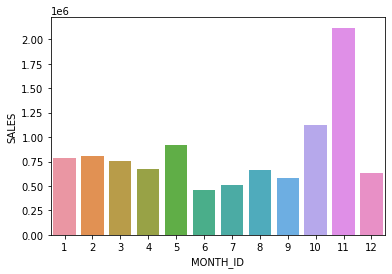

In [45]:
sns.barplot(x = sales_df_month_group.index, y = 'SALES', data = sales_df_month_group )

In [46]:
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

In [47]:
# We are dropping this date related columns because we already have a lot of date related columns such as month_id and year_id
sales_df.drop('ORDERDATE', axis =1, inplace = True)
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,1,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,3,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,3,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,4,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,4,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,1,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,1,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,1,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [48]:
sales_df.shape

(2823, 38)

In [49]:
sales_df.dtypes

QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
MSRP                  int64
PRODUCTCODE            int8
Australia             uint8
Austria               uint8
Belgium               uint8
Canada                uint8
Denmark               uint8
Finland               uint8
France                uint8
Germany               uint8
Ireland               uint8
Italy                 uint8
Japan                 uint8
Norway                uint8
Philippines           uint8
Singapore             uint8
Spain                 uint8
Sweden                uint8
Switzerland           uint8
UK                    uint8
USA                   uint8
Classic Cars          uint8
Motorcycles           uint8
Planes                uint8
Ships                 uint8
Trains                uint8
Trucks and Buses      uint8
Vintage Cars          uint8
Large               

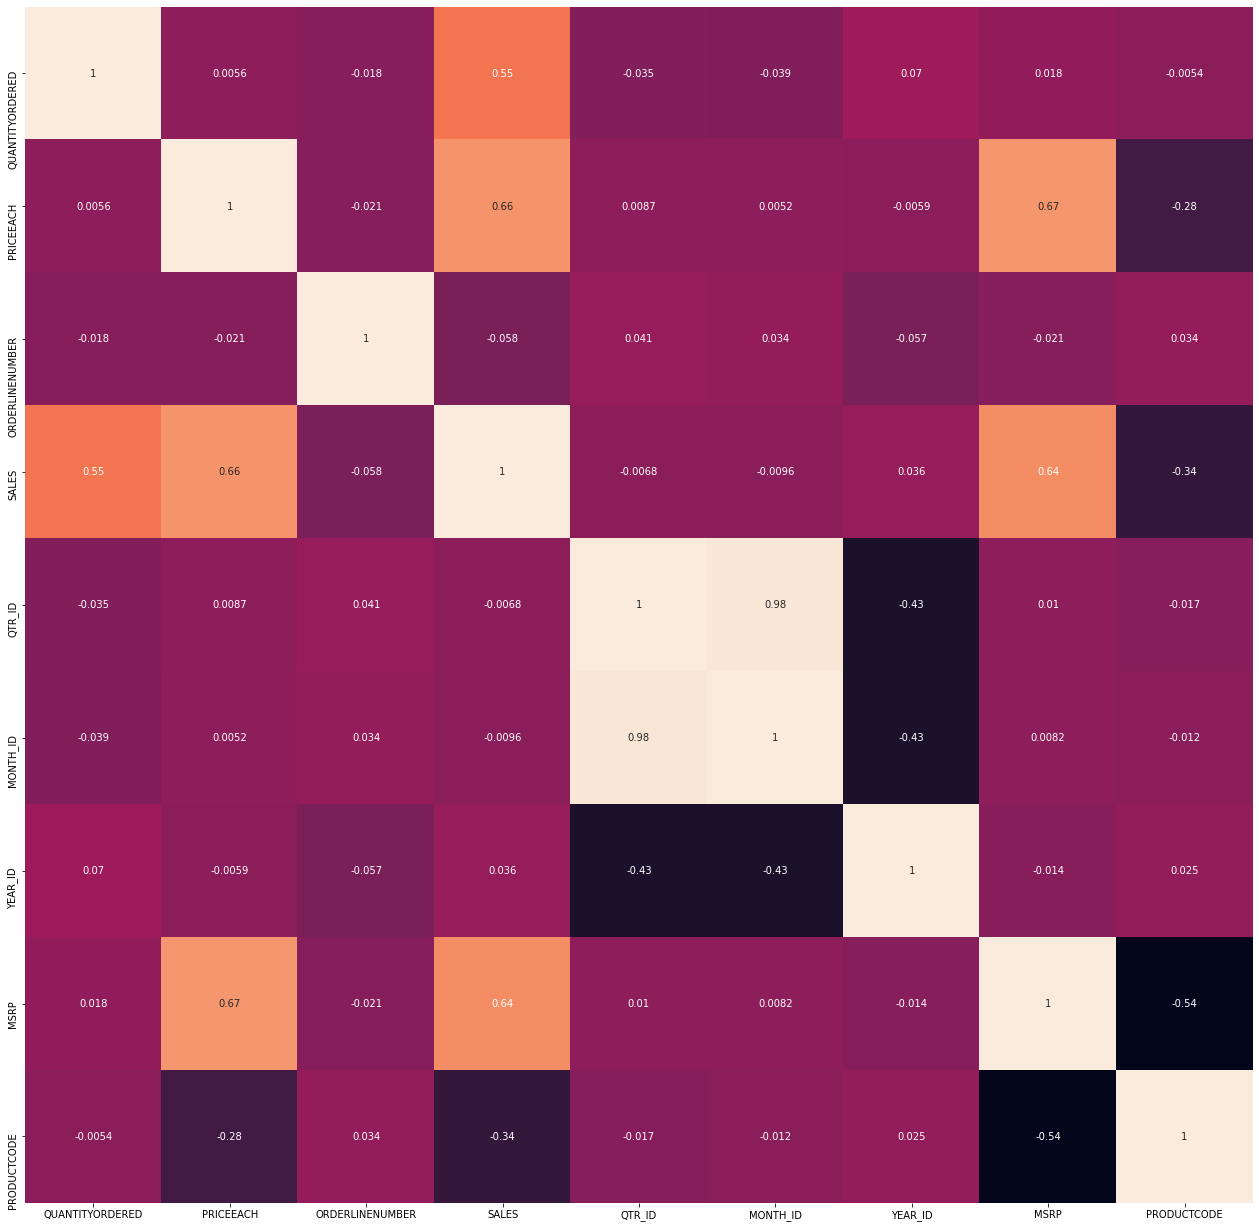

In [50]:
plt.figure(figsize = (22,22))
corr_matrix = sales_df.iloc[:, :9].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [51]:
sales_df.drop('QTR_ID', axis =1, inplace= True)
sales_df.shape

(2823, 37)

In [52]:
# Let's plot distplots
# Distplot shows the (1) histogram, (2) kde plot and (3) rug plot.
# (1) Histogram: it's a graphical display of data using bars with various heights. Each bar groups numbers into ranges and taller bars show that more data falls in that range.
# (2) Kde Plot: Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable.
# (3) Rug plot: plot of data for a single quantitative variable, displayed as marks along an axis (one-dimensional scatter plot). 

import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = sales_df.columns[i])
    fig.show()


<Figure size 720x720 with 0 Axes>

In [53]:
# Visualize the relationship between variables using pairplots
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()

# A trend exists between 'SALES' and 'QUANTITYORDERED'  
# A trend exists between 'MSRP' and 'PRICEEACH'  
# A trend exists between 'PRICEEACH' and 'SALES'
# It seems that sales growth exists as we move from 2013 to 2014 to 2015 ('SALES' vs. 'YEAR_ID')
# zoom in into 'SALES' and 'QUANTITYORDERED', you will be able to see the monthly information color coded on the graph


<Figure size 1080x1080 with 0 Axes>

#K-Means Clustering Algorithm

Apply Elbow method to find optimal number of clusters

In [54]:
# Scale the data
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [55]:
sales_df_scaled.shape

(2823, 37)

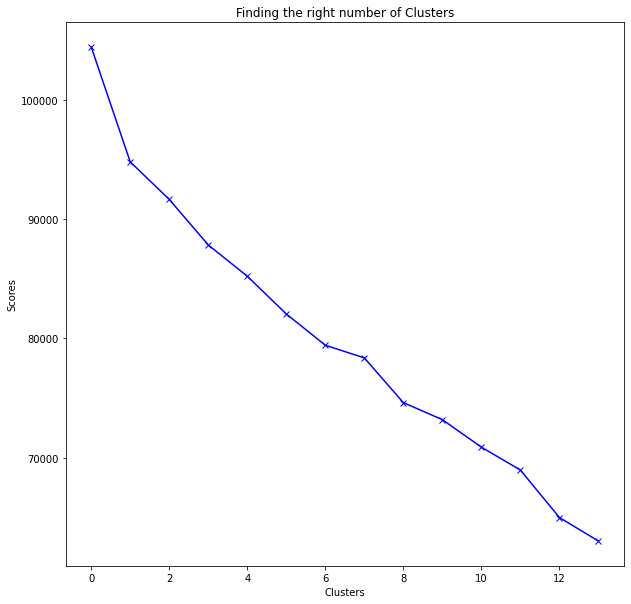

In [56]:
scores = []

range_values = range(1,15)

for i in range_values:
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_)

plt.figure(figsize=(10,10))
plt.plot(scores, 'bx-')
plt.title('Finding the right number of Clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores')
plt.show()

#Apply K-Means Method

In [57]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_

In [58]:
labels

array([3, 3, 1, ..., 1, 3, 1], dtype=int32)

In [59]:
kmeans.cluster_centers_.shape

(5, 37)

In [60]:
#Let's take a look at the cluster centers 

cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns= [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,-0.238120,-0.111504,0.374193,-0.305340,0.129536,-0.099789,-0.205639,0.209124,-0.264819,-0.140961,-0.108756,-0.159458,-0.151083,-0.183541,-0.353765,-0.149852,-0.075499,4.897173,-0.136988,-0.176195,-0.096414,-0.169676,-0.371278,-0.143553,-0.105371,-0.231843,-0.742934,-0.304345,-0.305805,0.592055,-0.095340,0.006298,-0.284337,0.418106,-0.242672,-0.150357,0.262666
1,0.302037,0.575070,-0.030349,0.457763,0.004963,0.006316,0.366228,-0.164333,0.002098,0.020190,-0.001572,0.003532,0.010106,0.015436,0.010210,0.007362,-0.014112,-0.204199,-0.017039,0.012571,0.016149,-0.169676,0.031225,0.025724,0.056766,0.016007,0.067295,0.100357,0.003197,-0.069499,-0.019286,-0.049573,0.050207,-0.070957,-0.242672,1.019676,-0.912100
2,-0.029274,-0.027627,0.096004,0.002030,0.006272,-0.413767,0.098333,-0.109335,-0.264819,-0.140961,-0.108756,-0.159458,-0.151083,-0.183541,-0.353765,-0.149852,-0.075499,-0.204199,-0.136988,-0.176195,-0.096414,5.893571,-0.371278,-0.143553,-0.105371,-0.231843,-0.742934,0.115670,-0.324602,-0.348674,-0.114641,0.226088,0.609936,-0.086488,-0.074847,-0.006159,0.040636
3,-0.471511,-0.725250,0.028714,-0.811879,-0.005636,0.009363,-0.576294,0.282081,0.049443,-0.006411,0.032803,0.036236,-0.002293,0.011648,0.033380,0.011641,0.014583,-0.204199,0.039033,0.011773,0.000925,-0.169676,0.027673,0.000683,-0.032370,0.033255,0.025191,-0.164282,0.042806,0.067347,0.076464,0.055697,-0.044195,0.065084,-0.242672,-0.980703,1.096370
4,1.247208,0.800027,-0.270171,2.575664,-0.091005,0.152939,1.422435,-0.866101,-0.081137,0.046965,-0.108756,-0.117700,0.112682,-0.000687,0.079940,0.027371,0.097499,0.027681,0.007886,0.013797,-0.028438,-0.130305,-0.032970,-0.051220,-0.105371,-0.113789,0.125200,0.564409,0.019040,-0.160686,-0.300637,-0.127589,-0.198194,-0.144036,4.120788,-0.980703,-0.912100


In [61]:
#In order to understand the data, we need to unscale the data

cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns=[sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,32.773585,81.409434,8.047170,2991.593208,7.566038,2003.745283,92.452830,60.377358,1.387779e-17,-3.469447e-17,-1.387779e-17,-3.816392e-17,1.387779e-17,6.938894e-18,9.714451e-17,4.857226e-17,1.040834e-17,1.000000e+00,3.122502e-17,7.632783e-17,-1.040834e-17,2.428613e-17,-2.081668e-16,-2.081668e-17,2.255141e-17,-5.551115e-17,0.000000e+00,0.198113,0.018868,2.924528e-01,5.660377e-02,0.028302,0.018868,0.386792,-7.632783e-17,4.150943e-01,5.849057e-01
1,38.034562,95.258111,6.337942,4396.878203,7.110599,2003.819508,115.430876,48.583717,6.605223e-02,2.227343e-02,1.152074e-02,2.534562e-02,2.380952e-02,3.533026e-02,1.144393e-01,2.304147e-02,4.608295e-03,-7.702172e-16,1.612903e-02,3.225806e-02,1.075269e-02,3.434752e-16,1.313364e-01,2.380952e-02,1.689708e-02,5.453149e-02,3.878648e-01,0.390169,0.118280,8.678955e-02,7.757296e-02,0.019201,0.122120,0.185868,-2.359224e-16,1.000000e+00,-8.160139e-15
2,34.807692,83.101282,6.871795,3557.627051,7.115385,2003.525641,104.666667,50.320513,1.387779e-17,-1.734723e-17,6.938894e-18,-3.122502e-17,1.387779e-17,4.163336e-17,8.326673e-17,4.163336e-17,6.071532e-18,-3.469447e-17,1.040834e-17,5.551115e-17,-1.040834e-17,1.000000e+00,-1.387779e-16,-6.938894e-18,0.000000e+00,2.081668e-17,-4.440892e-16,0.397436,0.012821,-1.526557e-16,5.128205e-02,0.064103,0.294872,0.179487,3.846154e-02,4.871795e-01,4.743590e-01
3,30.500423,69.029738,6.587489,2058.782815,7.071851,2003.821640,77.559594,62.681319,7.776839e-02,1.859679e-02,1.521555e-02,3.043111e-02,2.197802e-02,3.465765e-02,1.217244e-01,2.366864e-02,6.762468e-03,-6.661338e-16,2.366864e-02,3.212172e-02,9.298394e-03,3.400058e-16,1.301775e-01,2.028740e-02,7.607777e-03,5.832629e-02,3.677092e-01,0.264582,0.131023,1.293322e-01,1.039730e-01,0.036348,0.092984,0.241758,2.706169e-16,-1.054712e-15,1.000000e+00
4,47.240260,99.795649,5.324675,8297.075130,6.759740,2003.922078,157.870130,26.422078,4.545455e-02,2.597403e-02,-2.255141e-17,6.493506e-03,3.896104e-02,3.246753e-02,1.363636e-01,2.597403e-02,1.298701e-02,4.545455e-02,1.948052e-02,3.246753e-02,6.493506e-03,6.493506e-03,1.103896e-01,1.298701e-02,4.163336e-17,2.597403e-02,4.155844e-01,0.610390,0.123377,5.844156e-02,-1.110223e-16,0.006494,0.045455,0.155844,1.000000e+00,-7.771561e-16,1.110223e-15


Cluster 2 (Highest) - This group represents customers who buy items in high quantity centered around ~47, they buy items in all price range leaning towards high price items of ~99. They also correspond to the highest total sales around ~8296 and they are active throughout the year. They are the highest buyers of products with high MSRP ~158.

Cluster 0 - This group represents customers who buy items in varying quantity ~35, they tend to buy high price items ~96. Their sales is bit better average ~4435, they buy products with second highest MSRP of ~133.

Cluster 1 (lowest) - This group represents customers who buy items in low quantity ~30. They tend to buy low price items ~68. Their sales ~2020 is lower than other clusters and they are extremely active around holiday season. They buy products with low MSRP ~75.

Cluster 3 - This group represents customers who are only active during the holidays. they buy in lower quantity ~35, but they tend to buy average price items around ~83. They also correspond to lower total sales around ~3053, they tend to buy items with MSRP around 102.

Cluster 4 - This group represents customers who buy items in varying quantity ~39, they tend to buy average price items ~94. Their sales ~4329.

In [62]:
labels.shape 
#Labels associated to each data points

(2823,)

In [63]:
labels.max()

4

In [64]:
labels.min()

0

In [65]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans

array([2, 2, 3, ..., 4, 4, 4], dtype=int32)

In [66]:
y_kmeans.shape

(2823,)

In [67]:
# Add a label (which cluster) corresponding to each data point
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,3
1,34,81.35,5,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,3
2,41,94.74,2,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
3,45,83.26,6,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
4,49,100.00,14,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3


In [68]:
sales_df.dtypes

QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
MONTH_ID              int64
YEAR_ID               int64
MSRP                  int64
PRODUCTCODE            int8
Australia             uint8
Austria               uint8
Belgium               uint8
Canada                uint8
Denmark               uint8
Finland               uint8
France                uint8
Germany               uint8
Ireland               uint8
Italy                 uint8
Japan                 uint8
Norway                uint8
Philippines           uint8
Singapore             uint8
Spain                 uint8
Sweden                uint8
Switzerland           uint8
UK                    uint8
USA                   uint8
Classic Cars          uint8
Motorcycles           uint8
Planes                uint8
Ships                 uint8
Trains                uint8
Trucks and Buses      uint8
Vintage Cars          uint8
Large                 uint8
Medium              

In [69]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

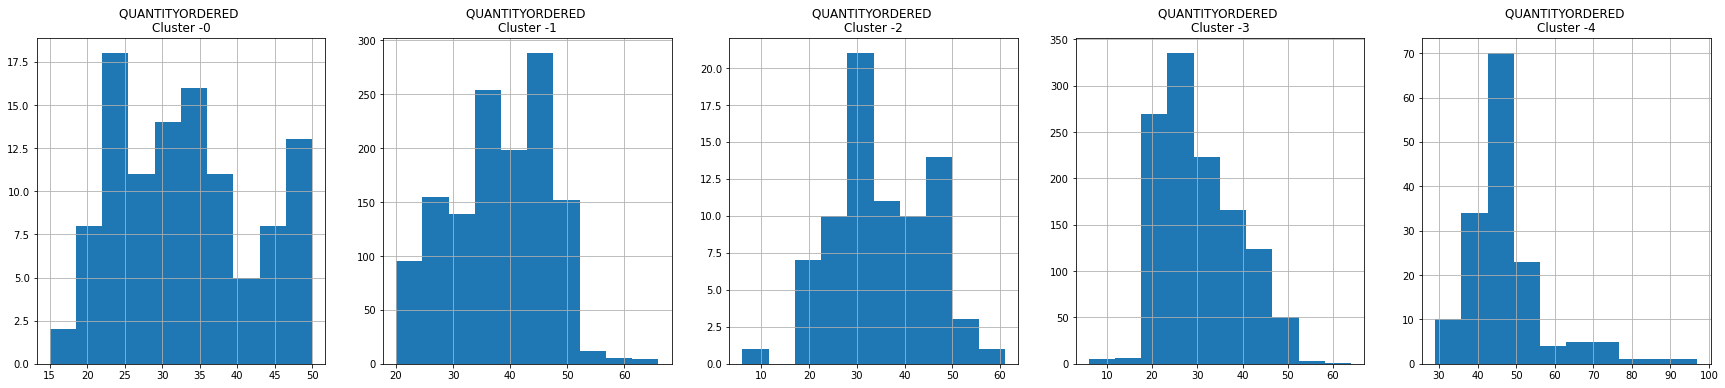

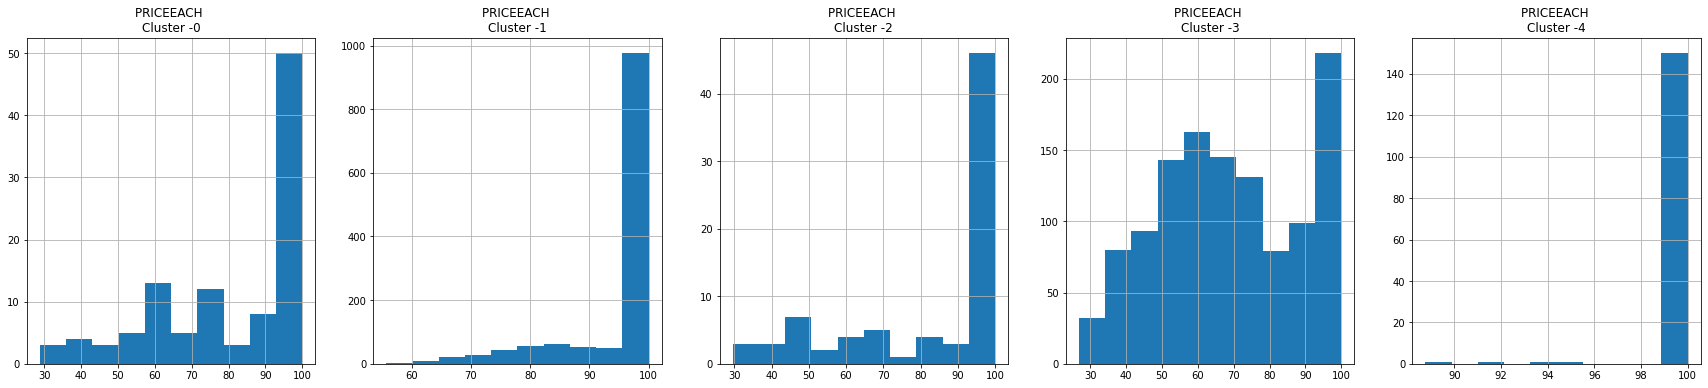

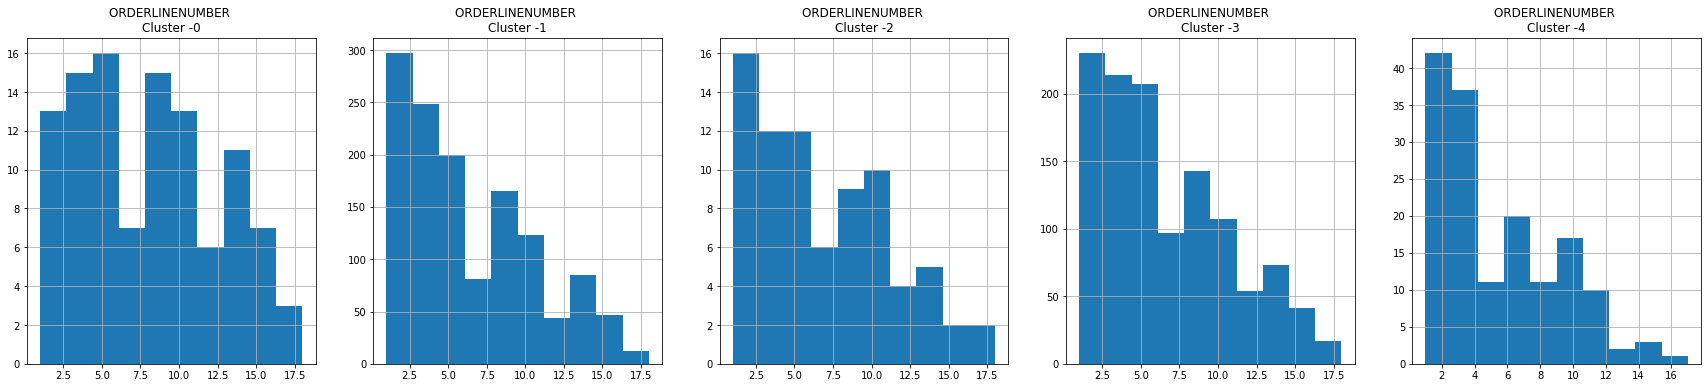

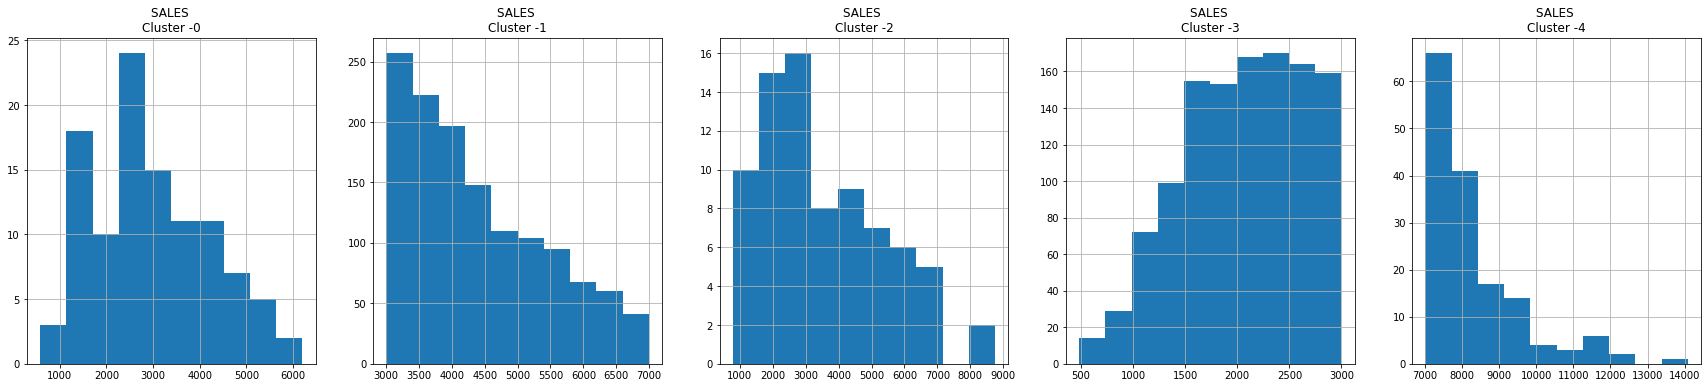

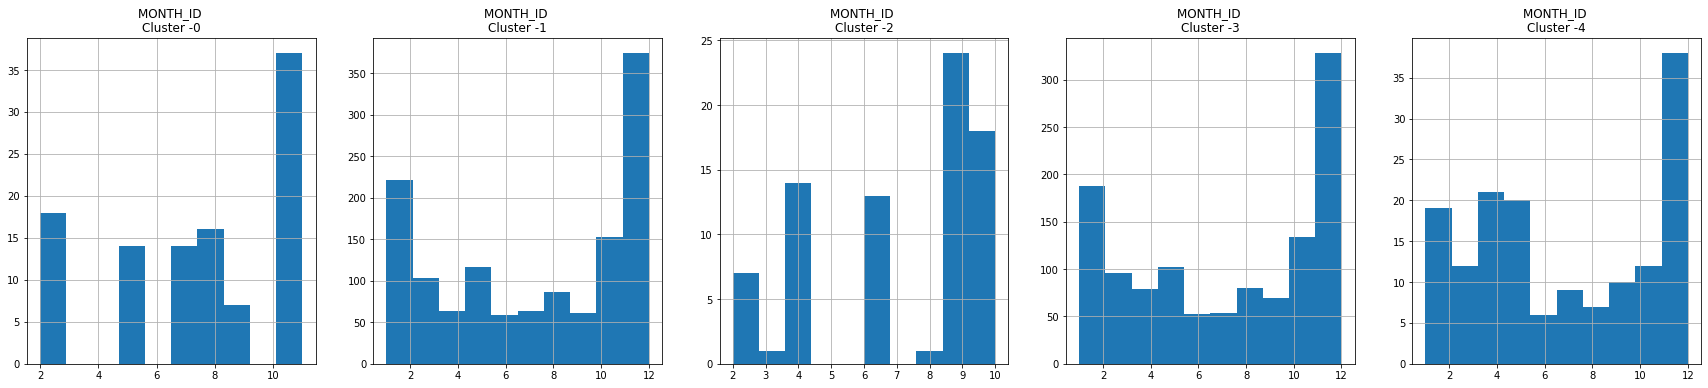

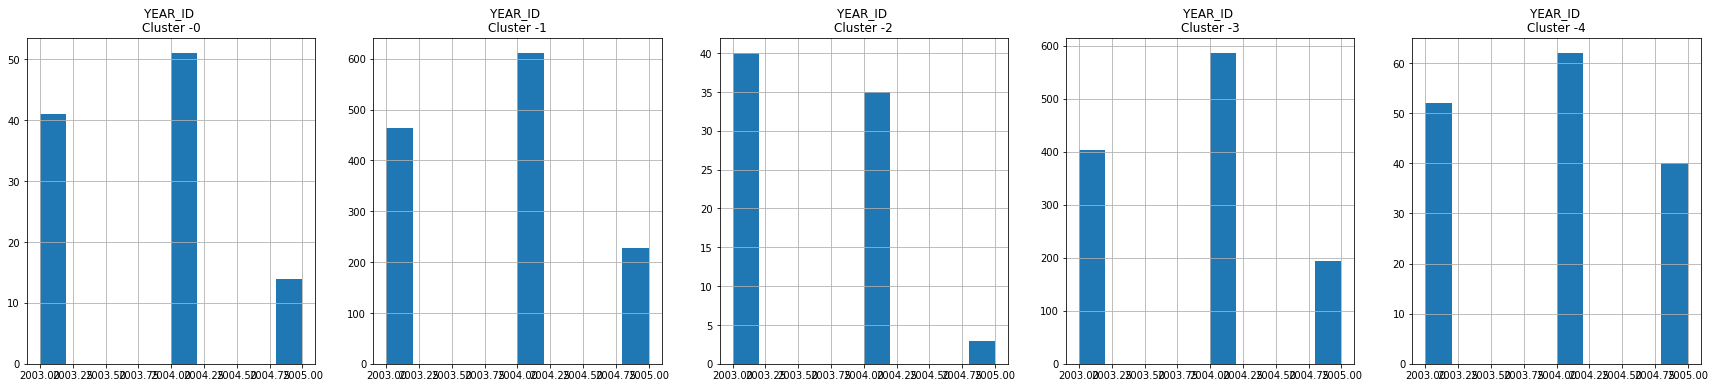

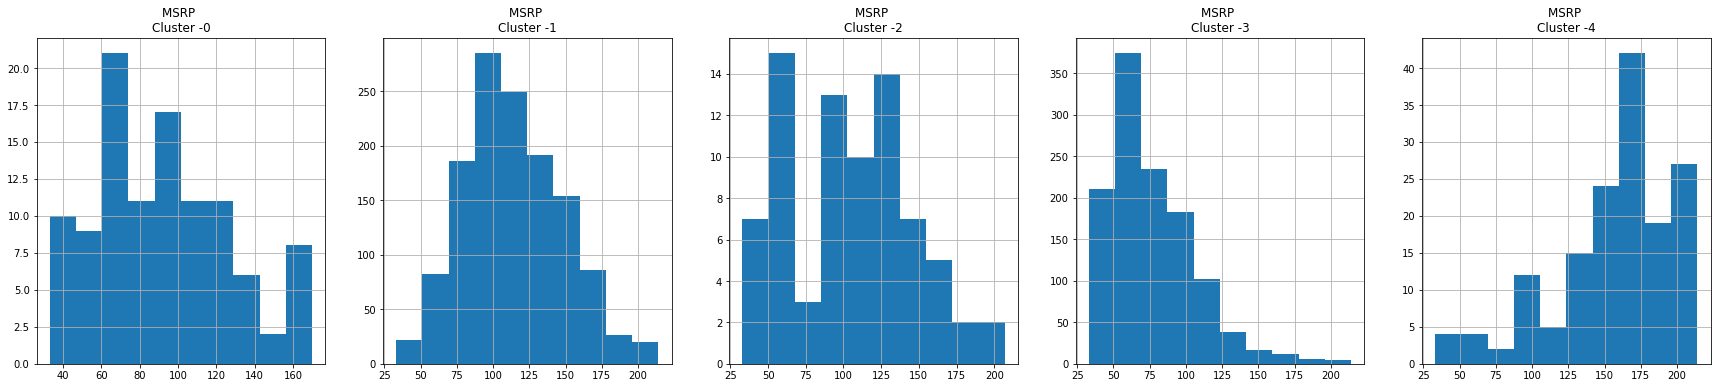

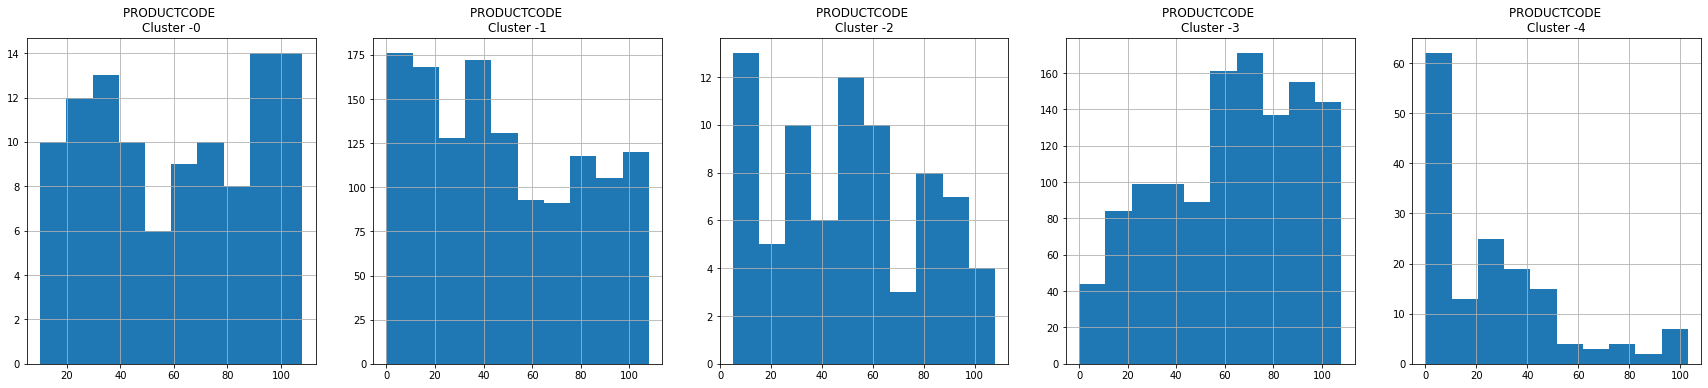

In [72]:
#Plot Histogram dor eaach feature based on Cluster
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1,5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{} \nCluster -{}'.format(i,j))
  plt.show()

#Apply PCA - Principal Component Analysis and Visualize results

In [73]:
# Reduce the original data to 3 dimensions using PCA for visualizig the clusters
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48649673, -1.1790369 ,  1.0051139 ],
       [-0.78487994, -0.96031499,  1.42978129],
       [ 1.43132954,  0.1747805 ,  0.28857494],
       ...,
       [ 0.38965033,  4.20358768,  0.03796442],
       [-2.78893671,  2.40411591,  1.64584726],
       [-0.70539691,  3.27249631, -0.47123932]])

In [74]:
pca_df = pd.DataFrame(principal_comp, columns=['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486497,-1.179037,1.005114
1,-0.784880,-0.960315,1.429781
2,1.431330,0.174780,0.288575
3,1.288345,-0.204078,-0.594449
4,1.975911,-0.101993,-1.085429


In [75]:
#Concatenate the cluster labels to the dataframe

pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})],axis = 1)
pca_df

,pca1,pca2,pca3,cluster
0,-0.486497,-1.179037,1.005114,3
1,-0.784880,-0.960315,1.429781,3
2,1.431330,0.174780,0.288575,1
3,1.288345,-0.204078,-0.594449,1
4,1.975911,-0.101993,-1.085429,1
...,...,...,...,...
2818,-2.450735,1.283631,-1.438318,3
2819,-0.158269,3.640302,0.730326,1
2820,0.389650,4.203588,0.037964,1
2821,-2.788937,2.404116,1.645847,3


In [76]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', 
              color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

#Mini Challenge 

In [77]:
# Reduce the original data to 3 dimensions using PCA for visualizig the clusters
pca = PCA(n_components = 2)
principal_comp_2 = pca.fit_transform(sales_df_scaled)
principal_comp_2

array([[-0.48625068, -1.1963056 ],
       [-0.78456212, -1.02644459],
       [ 1.4315278 ,  0.12667969],
       ...,
       [ 0.38973009,  4.1155203 ],
       [-2.78892355,  2.39776809],
       [-0.70559052,  3.30944546]])

In [78]:
pca_df_2 = pd.DataFrame(principal_comp_2, columns=['pca1', 'pca2'])
pca_df_2.head()

,pca1,pca2
0,-0.486251,-1.196306
1,-0.784562,-1.026445
2,1.431528,0.126680
3,1.288445,-0.225779
4,1.976054,-0.150450


In [79]:
#Concatenate the cluster labels to the dataframe

pca_df_2 = pd.concat([pca_df_2, pd.DataFrame({'cluster':labels})],axis = 1)
pca_df_2

,pca1,pca2,cluster
0,-0.486251,-1.196306,3
1,-0.784562,-1.026445,3
2,1.431528,0.126680,1
3,1.288445,-0.225779,1
4,1.976054,-0.150450,1
...,...,...,...
2818,-2.450428,1.098284,3
2819,-0.158171,3.683446,1
2820,0.389730,4.115520,1
2821,-2.788924,2.397768,3


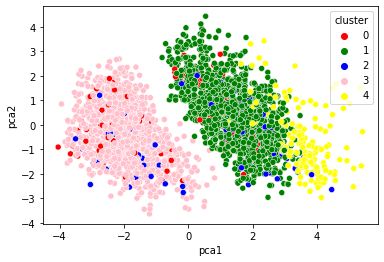

In [80]:
ax = sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df_2, palette = ['red', 'green', 'blue', 'pink', 'yellow'])
plt.show()

#Apply AutoEncoders (Perform Dimensionality reduction using AutoEncoders)


In [81]:
sales_df.shape

(2823, 37)

In [82]:
# from keras.optimizers import SGD

# Glorot Uniform initializer: https://keras.rstudio.com/reference/initializer_glorot_uniform.html

input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [83]:
autoencoder.fit(sales_df, sales_df, batch_size = 128, epochs = 500, verbose = 3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [84]:
autoencoder.save_weights('autoencoder_1_Ay.h5')

In [85]:
pred = autoencoder.predict(sales_df_scaled)

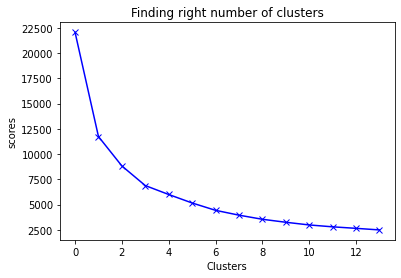

In [86]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [87]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

In [88]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2.0,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1
1,34,81.35,5.0,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
2,41,94.74,2.0,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
3,45,83.26,6.0,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
4,49,100.00,14.0,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1


In [89]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers 

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,-0.468912,-0.724370,0.043454,-0.810304,0.007142,-0.003285,-0.581757,0.285478,0.025174,-0.016801,0.021872,0.021124,-0.013783,-0.003425,0.003484,-0.000830,0.007626,0.042513,0.025440,-0.002742,-0.006592,0.005316,-0.003135,-0.010455,-0.038008,0.012783,-0.034126,-0.162957,0.013781,0.072858,0.058660,0.071986,-0.044714,0.087993,-0.242672,-0.980703,1.09637
1,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,-0.084647,0.043374,-0.108756,-0.118498,0.107642,-0.004181,0.071653,0.023985,0.094193,0.023250,0.005118,0.010166,-0.029737,-0.015199,-0.039435,-0.052984,-0.105371,-0.116045,0.108611,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.91210
2,0.293073,0.580208,-0.010805,0.458608,0.003368,-0.012482,0.376634,-0.165542,-0.013717,0.010642,-0.007922,-0.006125,0.000556,0.003647,-0.011355,-0.001952,-0.017750,-0.042017,-0.024145,0.001387,0.009480,-0.003200,0.007377,0.015695,0.047160,0.001323,0.019290,0.085141,-0.014094,-0.048853,-0.020232,-0.052121,0.064221,-0.064346,-0.242672,1.019676,-0.91210


In [90]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30.525741,69.047496,6.649766,2061.682800,7.118565,2003.812793,77.340094,62.788612,0.071763,0.017161,1.404056e-02,0.028081,0.020281,0.031981,0.112324,0.021841,0.006240,0.048362,0.021841,0.029641,0.008580,0.028861,0.120125,0.018721,7.020281e-03,0.053822,0.339314,0.265211,0.121685,0.131045,9.906396e-02,0.039002,0.092824,0.251170,-1.595946e-16,-1.054712e-15,1.000000e+00
1,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,0.044586,0.025478,-1.908196e-17,0.006369,0.038217,0.031847,0.133758,0.025478,0.012739,0.044586,0.019108,0.031847,0.006369,0.025478,0.108280,0.012739,4.336809e-17,0.025478,0.407643,0.617834,0.121019,0.057325,-1.110223e-16,0.006369,0.044586,0.152866,1.000000e+00,-7.771561e-16,9.992007e-16
2,37.947254,95.361741,6.420520,4398.433699,7.104769,2003.806358,115.848988,48.545520,0.062139,0.020954,1.083815e-02,0.023844,0.022399,0.033237,0.107659,0.021676,0.004335,0.031792,0.015173,0.030347,0.010116,0.027457,0.123555,0.022399,1.589595e-02,0.051301,0.364884,0.382948,0.112717,0.093208,7.731214e-02,0.018786,0.126445,0.188584,-5.273559e-16,1.000000e+00,-8.715251e-15


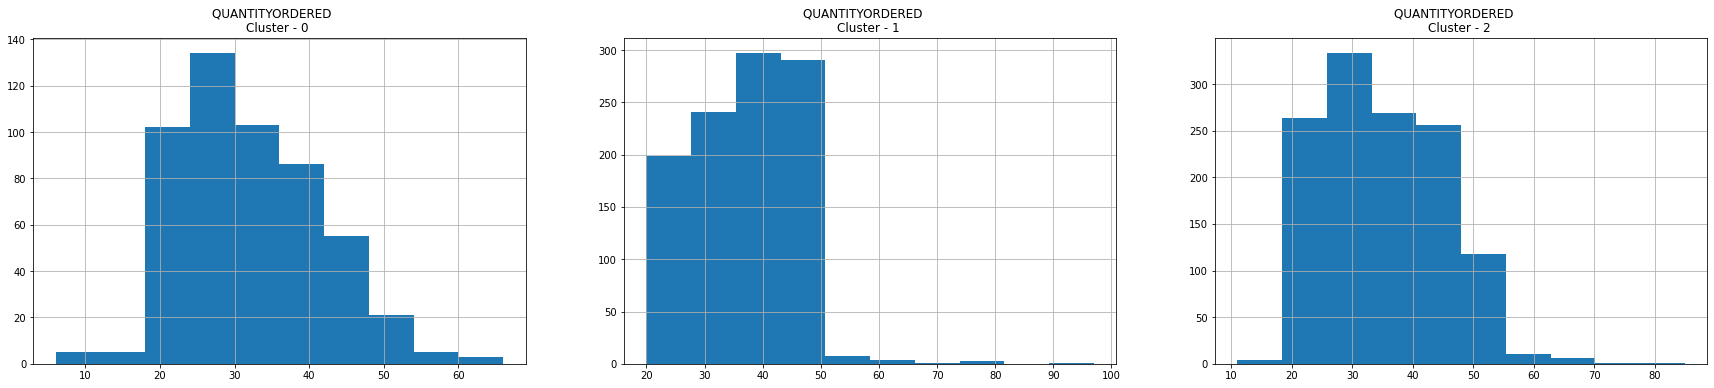

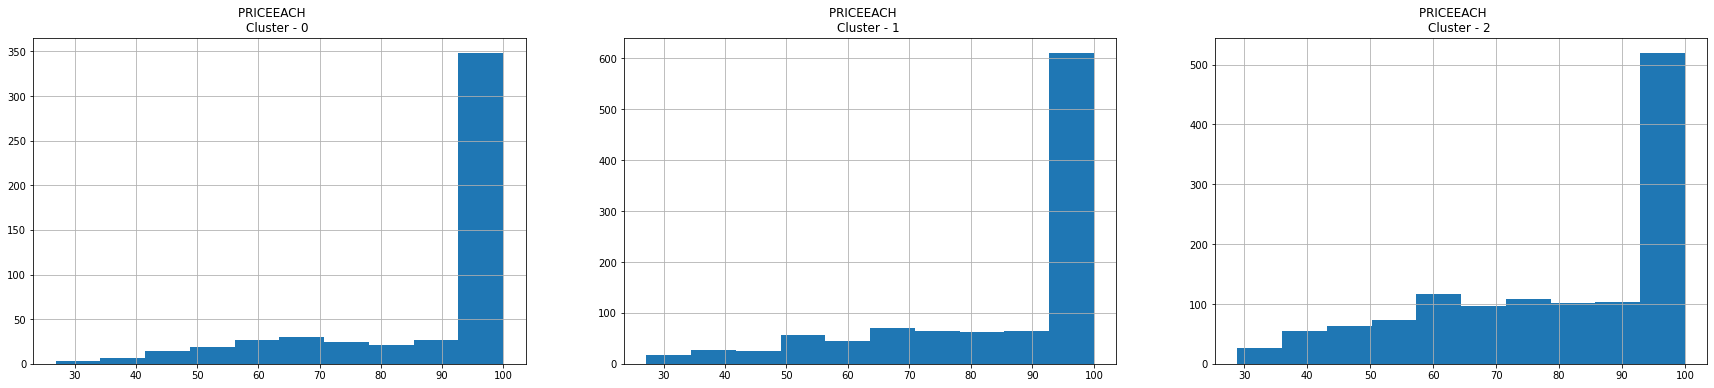

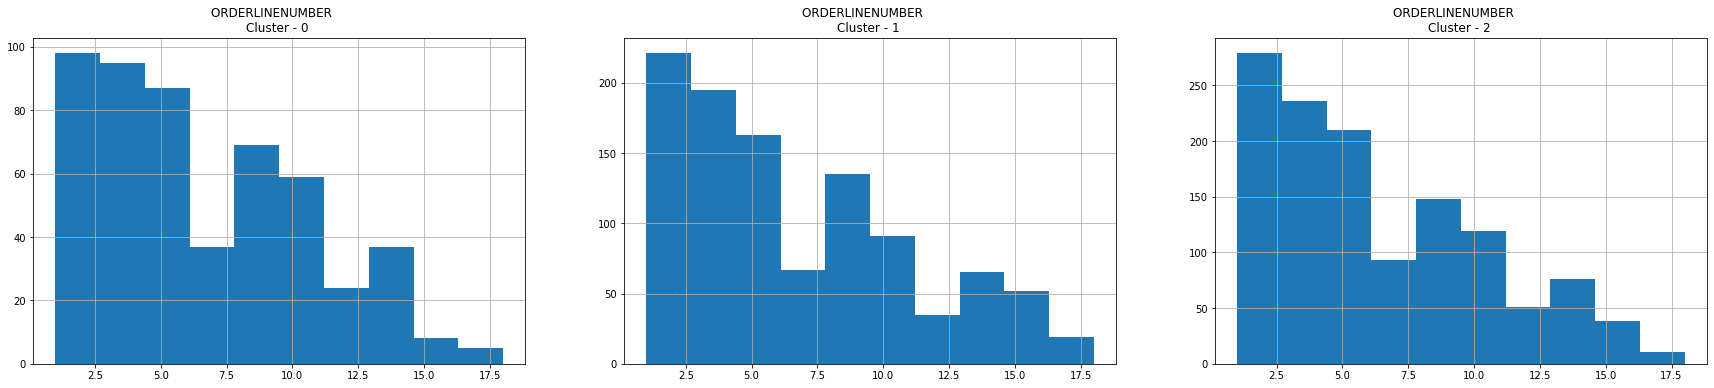

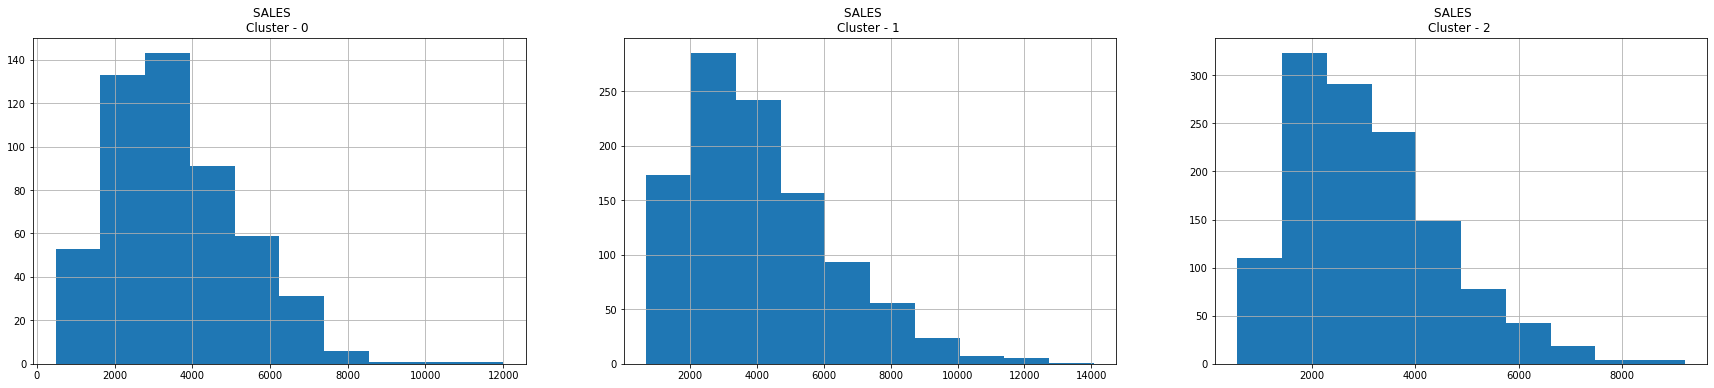

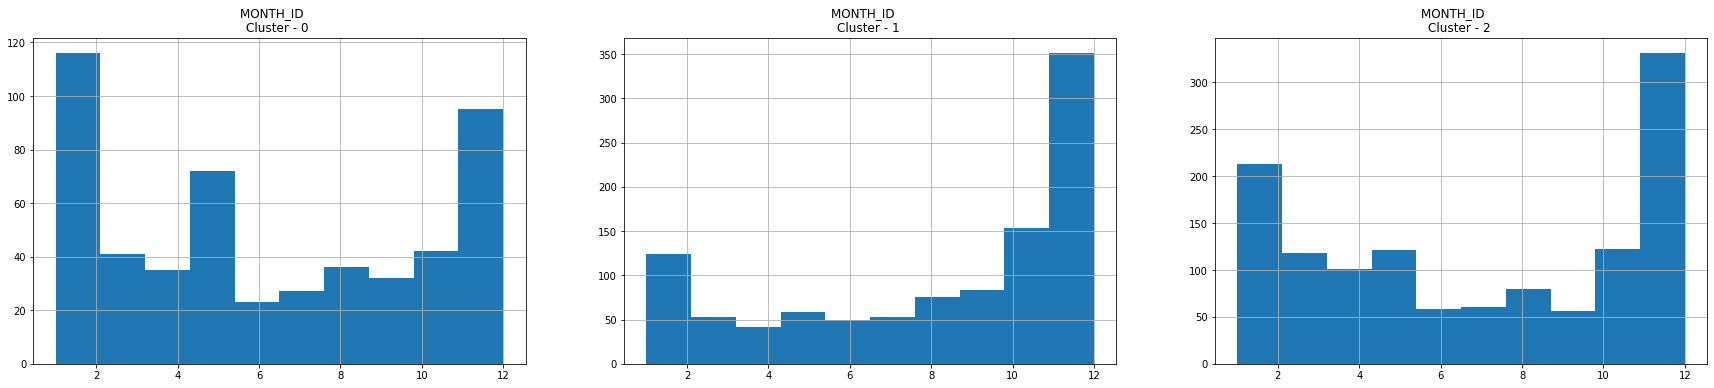

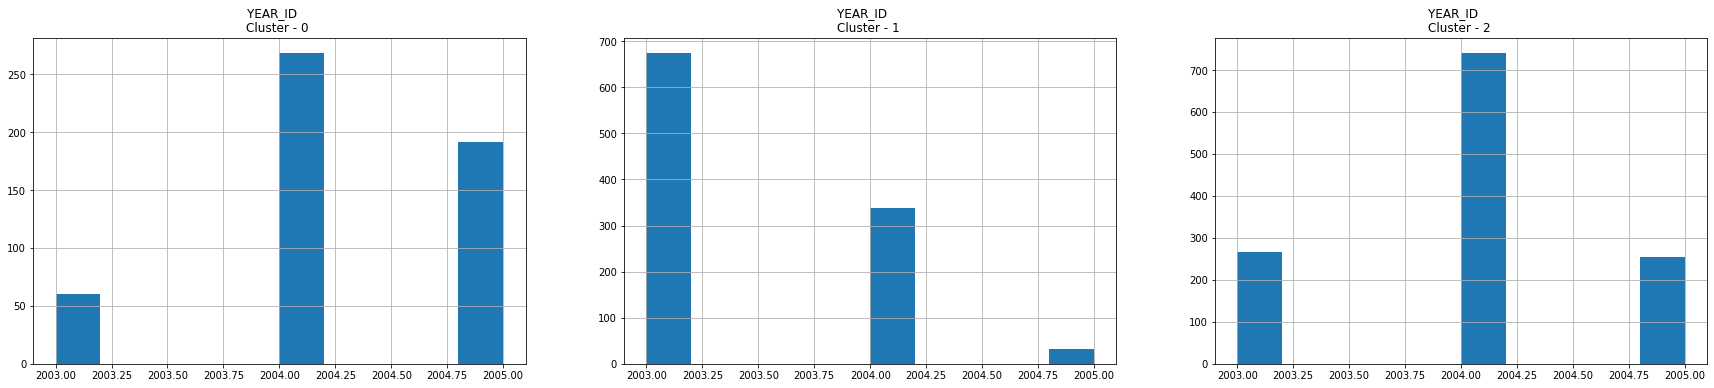

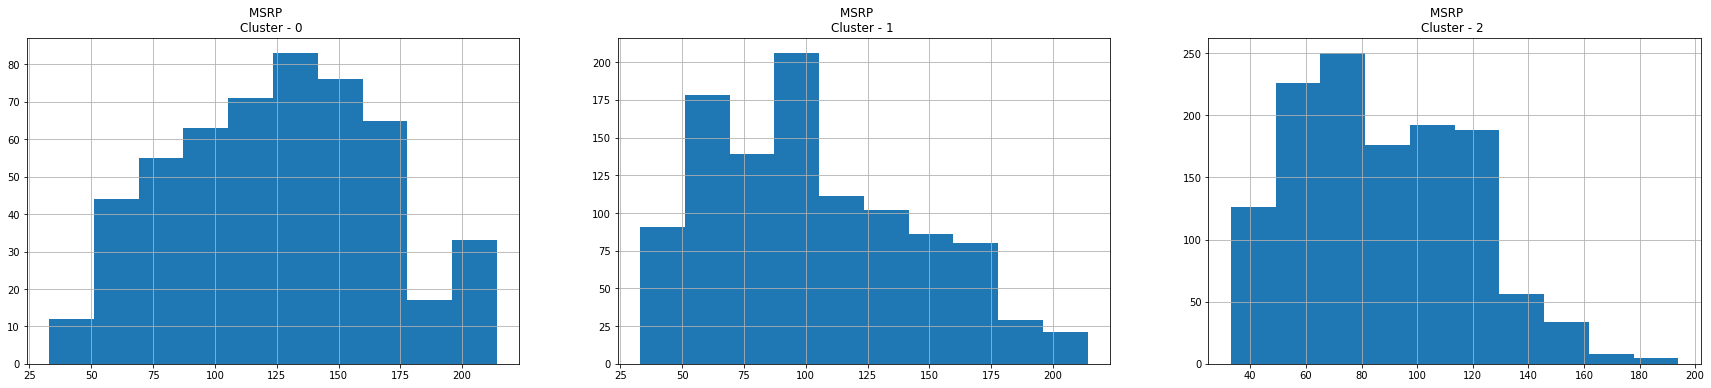

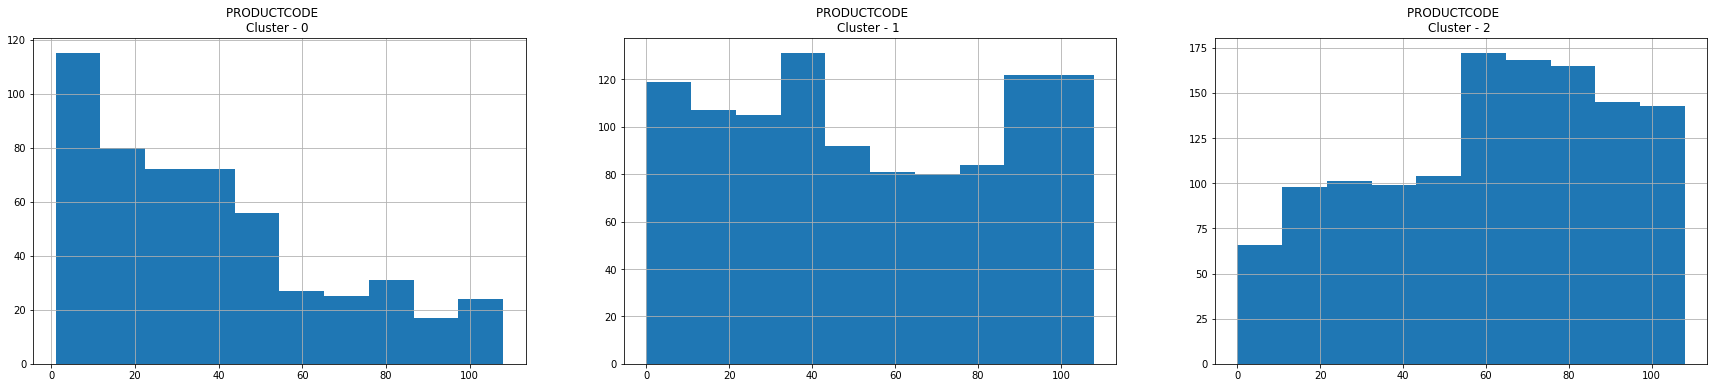

In [91]:
# plot histogram for each feature based on cluster 
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()

In [92]:
# Cluster 0 - This group represents customers who buy items in high quantity(47), they usually buy items with high prices(99). They bring-in more sales than other clusters. They are mostly active through out the year. They usually buy products corresponding to product code 10-90. They buy products with high mrsp(158).
# Cluster 1 - This group represents customers who buy items in average quantity(37) and they buy tend to buy high price items(95). They bring-in average sales(4398) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-10 and 90-100.Also they prefer to buy products with high MSRP(115) .
# Cluster 2 - This group represents customers who buy items in small quantity(30), they tend to buy low price items(69). They correspond to the lowest total sale(2061) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-20 and 100-110  they then to buy products with low MSRP(77).

In [93]:
# Reduce the original data to 3 dimension using PCA for visualize the clusters
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486276,-1.208457,0.795904
1,-0.784701,-1.052695,1.137609
2,1.431435,0.106242,-0.002009
3,1.288452,-0.201068,-0.776097
4,1.976018,-0.111844,-1.242540


In [94]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486276,-1.208457,0.795904,1
1,-0.784701,-1.052695,1.137609,2
2,1.431435,0.106242,-0.002009,1
3,1.288452,-0.201068,-0.776097,1
4,1.976018,-0.111844,-1.242540,1


In [95]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))